# Bayesian optimization integrating model hyper-parameters

In this notebook we are going to see how to use Emukit to solve optimization problems when the acquisition function is integrated with respect to the hyper-parameters of the model. 

To show this with an example, use the Six-hump camel function 

$$f(x_1,x_2) = \left(4-2.1x_1^2 = \frac{x_1^4}{3} \right)x_1^2 + x_1x_2 + (-4 +4x_2^2)x_2^2,$$

in $[-3,3]\times [-2,2]$. This functions has two global minima, at $(0.0898,-0.7126)$ and $(-0.0898,0.7126)$.



In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Loading the problem and generate initial data

In [2]:
from emukit.test_functions import sixhumpcamel_function
f, parameter_space = sixhumpcamel_function()

Now we define the domain of the function to optimize.

In [3]:
### --- Generate data
from emukit.experimental_design.model_free.random_design import RandomDesign

design = RandomDesign(parameter_space) # Collect random points
num_data_points = 5
X = design.get_samples(num_data_points)
Y = f(X)

## Train the model on the initial data

In [4]:
import GPy

model_gpy_mcmc = GPy.models.GPRegression(X,Y)
model_gpy_mcmc.kern.set_prior(GPy.priors.Uniform(0,5))
model_gpy_mcmc.likelihood.variance.constrain_fixed(0.001)

reconstraining parameters GP_regression.rbf


array([0])

We wrap the model in Emukit.

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,"[0, 5]"
rbf.lengthscale,1.0,+ve,"[0, 5]"
Gaussian_noise.variance,0.001,+ve fixed,


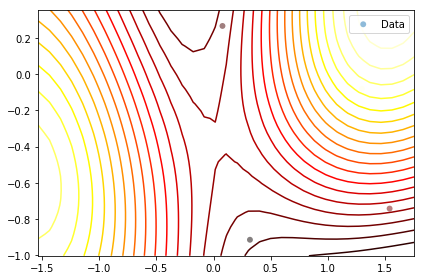

In [5]:
from emukit.model_wrappers import GPyModelWrapper
model_emukit = GPyModelWrapper(model_gpy_mcmc)
model_emukit.model.plot()
model_emukit.model

### Create the aquisition function

We use a combination of `IntegratedHyperParameterAcquisition` and `ExpectedImprovement` classes to create the integrated expected improvement acquisition object. The `IntegratedHyperParameterAcquisition` can convert any acquisition function into one that is integrated over model hyper-parameters.

We need to pass a function that will return an acquisition object to `IntegratedHyperParameterAcquisition`, this function takes in the model as an input only.

In [6]:
from emukit.core.acquisition import IntegratedHyperParameterAcquisition
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement

acquisition_generator = lambda model: ExpectedImprovement(model, jitter=0)
expected_improvement_integrated = IntegratedHyperParameterAcquisition(model_emukit, acquisition_generator)

In [7]:
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop

bayesopt_loop = BayesianOptimizationLoop(model = model_emukit,
                                         space = parameter_space,
                                         acquisition = expected_improvement_integrated,
                                         batch_size = 1)

We run the loop for 10 iterations.

In [8]:
max_iter = 10
bayesopt_loop.run_loop(f, max_iter)

Optimization restart 1/1, f = 8.116145760904836
Optimization restart 1/1, f = 9.45366807160581
Optimization restart 1/1, f = 11.74773417896987
Optimization restart 1/1, f = 13.506754974901929
Optimization restart 1/1, f = 14.857079110242797
Optimization restart 1/1, f = 16.867594076783146
Optimization restart 1/1, f = 18.06941705490323
Optimization restart 1/1, f = 19.058862694437813
Optimization restart 1/1, f = 20.412557656775697
Optimization restart 1/1, f = 21.70210676570288
Optimization restart 1/1, f = 24.545778595295648


Now, once the loop is completed we can visualize the distribution of the hyperparameters given the data.

Text(0, 0.5, 'Frequency')

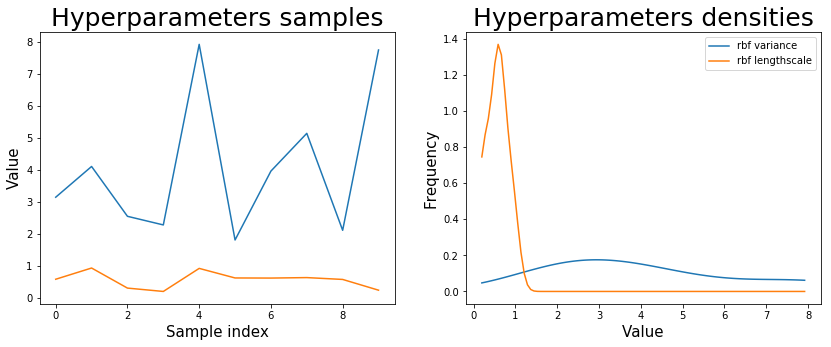

In [9]:
labels = ['rbf variance', 'rbf lengthscale']

plt.figure(figsize=(14,5))
samples = bayesopt_loop.candidate_point_calculator.acquisition.samples

plt.subplot(1,2,1)
plt.plot(samples,label = labels)
plt.title('Hyperparameters samples',size=25)
plt.xlabel('Sample index',size=15)
plt.ylabel('Value',size=15)

plt.subplot(1,2,2)
from scipy import stats
xmin = samples.min()
xmax = samples.max()
xs = np.linspace(xmin,xmax,100)
for i in range(samples.shape[1]):
    kernel = stats.gaussian_kde(samples[:,i])
    plot(xs,kernel(xs),label=labels[i])
_ = legend()
plt.title('Hyperparameters densities',size=25)
plt.xlabel('Value',size=15)
plt.ylabel('Frequency',size=15)

And we can check how the optimization evolved when you integrate out the acquisition.

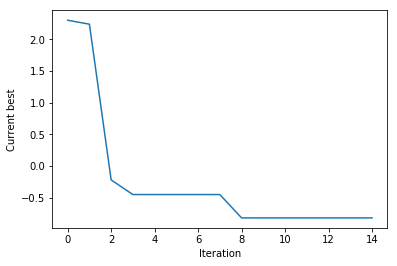

In [10]:
plt.plot(np.minimum.accumulate(bayesopt_loop.loop_state.Y))
plt.ylabel('Current best')
plt.xlabel('Iteration');